<a href="https://colab.research.google.com/github/artigenius/portfolio/blob/main/texts_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Сентимент анализ текстов песен Radiohead



# 1 Введение

**Цель проекта**: произвести сентимент анализ текстов песен Rediohead из всех вышедших альбомов группы и визуализировать полученный результат

**Задачи**:
- Найти датасет, содержащий всю необходимую информацию
- Произвести предварительную чистку данных
- Произвести токкенизацию и "чистку" текстовых данных
- Провести sentiment analyse текстов
- Визуализировать полученные данные


# 2 Датасет

- Выбрать, описать и загрузить источник используемых данных




Готовый датасет был выгружен с [сайта](https://data.world/rcharlie/gloom-index-of-radiohead-songs).
Изначальной идеей было провести самостоятельный сбор данных с помощью API Genius, но в ходе работы данных метод оказался менее результативным и вызывал больше проблем, чем давал результатов. Поэтому было принято решение анализировать готовый сет данных.

Загрузим необходимый файл в личный репозиторий гугл-диска и подключим его к коллабу, чтобы быстро подгружать любой файл в будущем.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Импортируем библиотеки для анализа данных и его последующей визуализации.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns

from wordcloud import WordCloud
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go

In [ ]:
# так как данные в таблице записаны в другой кодировке, нам необходимо дополнительно их раскодировать
df = pd.read_csv('/content/drive/MyDrive/radiohead.csv', encoding='cp1252')
# отобразим полученные данные
df.head(5)

,track_name,valence,duration_ms,lyrics,album_name,album_release_year,album_img,pct_sad,word_count,lyrical_density,gloom_index
0,You,0.305,208667,you are the sun and moon and stars are you and...,Pablo Honey,1993,https://i.scdn.co/image/e17011b2aa33289dfa6c08...,0.0000,19,0.091054,50.39
1,Creep,0.096,238640,when you were here before couldn't look you in...,Pablo Honey,1993,https://i.scdn.co/image/e17011b2aa33289dfa6c08...,0.0784,51,0.213711,22.60
2,How Do You?,0.264,132173,he's bitter and twisted he knows what he wants...,Pablo Honey,1993,https://i.scdn.co/image/e17011b2aa33289dfa6c08...,0.0952,21,0.158883,36.56
3,Stop Whispering,0.279,325627,and the wise man said i don't want to hear you...,Pablo Honey,1993,https://i.scdn.co/image/e17011b2aa33289dfa6c08...,0.0435,46,0.141266,43.48
4,Thinking About You,0.419,161533,been thinking about you your records are here ...,Pablo Honey,1993,https://i.scdn.co/image/e17011b2aa33289dfa6c08...,0.0000,39,0.241437,60.80


Начнем работу с данными. Для начала проверим, какой тип данных находится в каждом стобце и присутствуют ли пустые ячейки.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   track_name          101 non-null    object 
 1   valence             101 non-null    float64
 2   duration_ms         101 non-null    int64  
 3   lyrics              98 non-null     object 
 4   album_name          101 non-null    object 
 5   album_release_year  101 non-null    int64  
 6   album_img           101 non-null    object 
 7   pct_sad             101 non-null    float64
 8   word_count          101 non-null    int64  
 9   lyrical_density     101 non-null    float64
 10  gloom_index         101 non-null    float64
dtypes: float64(4), int64(3), object(4)
memory usage: 8.8+ KB


Мы видим, что единственные пустые строки находятся в столбце lyrics. Это может быть связано с тем, что данные треки не имеют текста, т.к. являются инструментальными. Так или иначе, для нашего анализа они представляют помеху, поэтому мы можем смело их удалить и сразу записать в новую переменную, в которой этих треков не будет.

In [ ]:
df_nan = df.dropna()
df_nan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98 entries, 0 to 100
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   track_name          98 non-null     object 
 1   valence             98 non-null     float64
 2   duration_ms         98 non-null     int64  
 3   lyrics              98 non-null     object 
 4   album_name          98 non-null     object 
 5   album_release_year  98 non-null     int64  
 6   album_img           98 non-null     object 
 7   pct_sad             98 non-null     float64
 8   word_count          98 non-null     int64  
 9   lyrical_density     98 non-null     float64
 10  gloom_index         98 non-null     float64
dtypes: float64(4), int64(3), object(4)
memory usage: 9.2+ KB


Для красоты и удобства представления данных, удалим в таблице столбцы с данными, которые нам не понадобятся.

In [ ]:
df_nan.drop(['valence', 'duration_ms', 'album_img', 'pct_sad', 'word_count', 'lyrical_density', 'gloom_index'], axis = 1, inplace = True)
df_nan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98 entries, 0 to 100
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   track_name          98 non-null     object
 1   lyrics              98 non-null     object
 2   album_name          98 non-null     object
 3   album_release_year  98 non-null     int64 
dtypes: int64(1), object(3)
memory usage: 3.8+ KB


<ipython-input-90-8f7c9e26d756>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# 3 Sentiment analysis

Следующим этапом является сентимент анализ текстов песен.
Для этого нам необходимо загрузить библиотеки для nlp анализа текста.

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

Очистим текст от ненужных символов и пунктуации.

In [ ]:
# let's удалим ненужные символы из текста
import string
def text_cleaned(text):
  text = text.str.replace('[\(\[].*?[\)\]]', '')
  text = text.str.replace('\n', '')
  text = text.str.replace('[{}]'.format(string.punctuation), '')
  text = text.str.lower()
  return text

# запишем очищенный текст в новую колонку lyrics_no_punkt
df_nan.loc[:, 'lyrics_no_punkt'] = text_cleaned(df_nan.loc[:, 'lyrics'])
df_nan.head()

<ipython-input-93-f509f4b8341a>:4: FutureWarning:

The default value of regex will change from True to False in a future version.

<ipython-input-93-f509f4b8341a>:6: FutureWarning:

The default value of regex will change from True to False in a future version.

<ipython-input-93-f509f4b8341a>:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,track_name,lyrics,album_name,album_release_year,lyrics_no_punkt
0,You,you are the sun and moon and stars are you and...,Pablo Honey,1993,you are the sun and moon and stars are you and...
1,Creep,when you were here before couldn't look you in...,Pablo Honey,1993,when you were here before couldnt look you in ...
2,How Do You?,he's bitter and twisted he knows what he wants...,Pablo Honey,1993,hes bitter and twisted he knows what he wants ...
3,Stop Whispering,and the wise man said i don't want to hear you...,Pablo Honey,1993,and the wise man said i dont want to hear your...
4,Thinking About You,been thinking about you your records are here ...,Pablo Honey,1993,been thinking about you your records are here ...


Следующим этапом мы удаляем из текста все стоп-слова и музыклаьных слэнг, которые могут помешать при дальшейнем анализе.

In [ ]:
def remove_stopwords(text):
    clean_text = list()
    nltk.download('punkt')
    nltk.download('stopwords')

    words =["yeah","ya","na","wan","uh","gon","ima","mm","uhhuh","bout","em","nigga","niggas","got","ta","lil","ol","hey",
          "oooh","ooh","oh","youre","dont","im","youve","ive","theres","ill","yaka","lalalala","la","da","di","yuh",
          "shawty","oohooh","shoorah","mmmmmm","ook","bidibambambambam","shh","bro","ho","aint","cant","know","bambam",
          "shitll","tonka"]
    ignore = (stopwords.words('english') + words)

    for i in text:
        words = nltk.word_tokenize(i) # токенизируем каждое слово в тектсе
        for element in ignore: # из токенизированного текста возвращаем список 'чистого текста'
            words = list(filter(lambda x: x!= element and len(x) > 1, words))
        lyric = " ".join(words)
        clean_text.append(lyric)

    return clean_text

# применим функицю к колонке с текстом без пунктуации
df_nan['lyrics_cleaned'] = remove_stopwords(df_nan['lyrics_no_punkt'])
df_nan.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
<ipython-input-94-a7f09faa34b5>:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,track_name,lyrics,album_name,album_release_year,lyrics_no_punkt,lyrics_cleaned
0,You,you are the sun and moon and stars are you and...,Pablo Honey,1993,you are the sun and moon and stars are you and...,sun moon stars could never run away try workin...
1,Creep,when you were here before couldn't look you in...,Pablo Honey,1993,when you were here before couldnt look you in ...,couldnt look eye like angel skin makes cry flo...
2,How Do You?,he's bitter and twisted he knows what he wants...,Pablo Honey,1993,hes bitter and twisted he knows what he wants ...,hes bitter twisted knows wants wants loved wan...
3,Stop Whispering,and the wise man said i don't want to hear you...,Pablo Honey,1993,and the wise man said i dont want to hear your...,wise man said want hear voice thin man said wa...
4,Thinking About You,been thinking about you your records are here ...,Pablo Honey,1993,been thinking about you your records are here ...,thinking records eyes wall teeth still one sta...


Начнем сентимент анализ. Для этого загрузим библиотеку и напишем цикл для проверки всего текста в колонке 'lyrics cleaned', которую мы для этого подготовили.

In [ ]:
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

comp_score = [] # общий результат сентимент-анализа будет записан в этом списке
sentiment = [] # финальный "вердикт" анализа в другой колонке

for i in df_nan.loc[:,'lyrics_cleaned']:
    sentiment.append(sia.polarity_scores(i))

# 'Вердикт'(Compound) будет выноситься по сумме всех результатов и далее выровнен по среднему значению
df_nan.loc[:,'sent_scores'] = sentiment
df_nan.loc[:,'comp_score'] = df_nan.loc[:,'sent_scores'].apply(lambda x: x['compound'])
df_nan.loc[:,'sentiment'] = df_nan.loc[:,'comp_score'].apply(lambda x: 'Positive' if x>=0.5 else 'Negative' if x<=-0.5 else 'Neutral')
df_nan.head()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
<ipython-input-96-cf154be223a8>:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-96-cf154be223a8>:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-96-cf154be223a8>:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

,track_name,lyrics,album_name,album_release_year,lyrics_no_punkt,lyrics_cleaned,sent_scores,comp_score,sentiment
0,You,you are the sun and moon and stars are you and...,Pablo Honey,1993,you are the sun and moon and stars are you and...,sun moon stars could never run away try workin...,"{'neg': 0.28, 'neu': 0.613, 'pos': 0.107, 'com...",-0.7845,Negative
1,Creep,when you were here before couldn't look you in...,Pablo Honey,1993,when you were here before couldnt look you in ...,couldnt look eye like angel skin makes cry flo...,"{'neg': 0.268, 'neu': 0.329, 'pos': 0.403, 'co...",0.8855,Positive
2,How Do You?,he's bitter and twisted he knows what he wants...,Pablo Honey,1993,hes bitter and twisted he knows what he wants ...,hes bitter twisted knows wants wants loved wan...,"{'neg': 0.378, 'neu': 0.379, 'pos': 0.243, 'co...",-0.8176,Negative
3,Stop Whispering,and the wise man said i don't want to hear you...,Pablo Honey,1993,and the wise man said i dont want to hear your...,wise man said want hear voice thin man said wa...,"{'neg': 0.217, 'neu': 0.661, 'pos': 0.122, 'co...",-0.5560,Negative
4,Thinking About You,been thinking about you your records are here ...,Pablo Honey,1993,been thinking about you your records are here ...,thinking records eyes wall teeth still one sta...,"{'neg': 0.029, 'neu': 0.595, 'pos': 0.375, 'co...",0.9822,Positive


# 4 Анализ полученных данных

Проведем сопоставительный анализ и построим график для каждого альбома и сентимент анализа треков в нем.

In [ ]:
df_song_sent = pd.DataFrame(df_nan.groupby(['album_name', 'sentiment'])['track_name'].count())
df_song_sent.columns = ['song_count']

df_song_sent = df_song_sent.reset_index()
df_song_sent = df_song_sent.sort_values(by=['album_name', 'song_count'])

fig = px.bar(df_song_sent, x = 'album_name', y = 'song_count', color = 'sentiment',
             labels = {'album_name': 'Name of the album',
                      'song_count': 'Number of the songs',
                       'sentiment': 'Sentiment'},
             title = 'Song Sentiments by Album',
             height = 400, width = 900)
fig.show()

Построим диаграмму рассеяния для отображения конечного результата сентимент анализа по каждой песне и год ее выхода.

(1990.0, 2015.0)

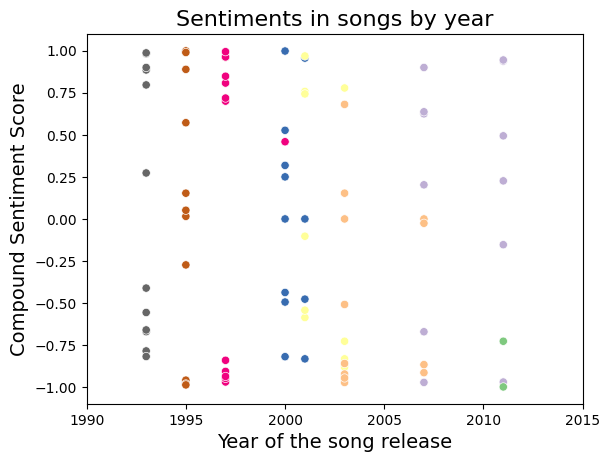

In [ ]:
# для того, чтобы наш график был красивым, создадим массив для каждой точки, который потом будет раскрашиваться
colors = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98])
sns.scatterplot(data = df_nan,
                x = 'album_release_year', y = 'comp_score',
                c = colors, cmap = 'Accent_r')
# подпишем названия всех осей и название графика, а также укажем шрифт подписи
plt.xlabel('Year of the song release', fontsize = 14)
plt.ylabel('Compound Sentiment Score', fontsize = 14)
plt.title('Sentiments in songs by year', fontsize = 16)

# настроим шаг по оси х для корректного отображения годов
plt.xlim([1990, 2015])

Проанализируем самые частотные слова для каждой категории треков (Позитивный или Негативный). Для этого составим мешок слов, который после визуализируем с помощью wordcloud.

In [ ]:
# создадим два списка слов
pos_sent = df_nan[df_nan['sentiment'] =='Positive']
neg_sent = df_nan[df_nan['sentiment'] =='Negative']

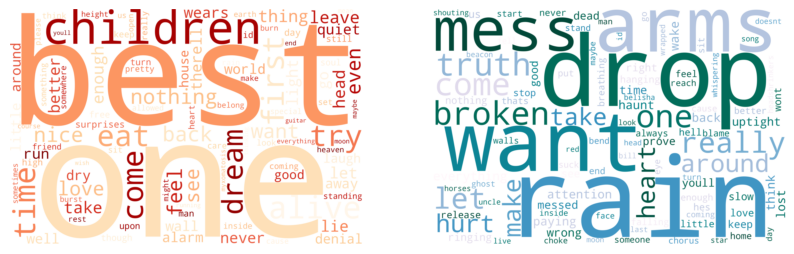

In [ ]:
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
wordcloud1 = WordCloud(collocations = False,
                      background_color = 'white',max_words = 100, colormap = 'OrRd', repeat = False,
                      width=3000, height=2000).generate(' '.join(pos_sent['lyrics_cleaned']))
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis("off")

plt.subplot(1,2,2)
wordcloud2 = WordCloud(collocations = False,
                      background_color = 'white',max_words = 100, colormap = 'PuBuGn', repeat = False,
                      width=3000, height=2000).generate(' '.join(neg_sent['lyrics_cleaned']))
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis("off")

plt.show()

Для наглядности, самые частотные "Позитивне" слова отображены в ярких красных тонах, тогда как "Негативные" в голубых.